In [1]:
import numpy as np
import cv2
import struct
import math
import time
import os
import math
import time
import sys
import PIL
from models import *
import torchvision.transforms as transforms
from torch.autograd import Variable
#from models import *
import torch.nn as nn
import torch.nn.functional as F
import torch
from ssd import build_ssd
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import pandas as pd
import scipy.misc
import random
import sys

In [44]:
n_class = 5
width = 640
height = 480
cuda = True if torch.cuda.is_available() else False
prob_threshold = 0.25
border = 10
Tensor = torch.cuda.FloatTensor if cuda else torch.FloatTensor
data_transform = transforms.Compose([transforms.Resize((256, 256), PIL.Image.BICUBIC),
                transforms.ToTensor()])
net = build_ssd('test', 300, 5)    # initialize SSD
net.load_weights('/media/arg_ws3/5E703E3A703E18EB/research/pst900_ssd/model/pst900_440.pth')
generator = GeneratorUNet(in_channels=3, out_channels=1)
generator_2ch = GeneratorUNet(in_channels=3, out_channels=2)
generator.load_state_dict(torch.load('/media/arg_ws3/5E703E3A703E18EB/research/pix2pix_cropmask/saved_models/rgb/generator_10.pth'))
generator_2ch.load_state_dict(torch.load('/media/arg_ws3/5E703E3A703E18EB/research/pix2pix_cropmask/saved_models/pst_pix_adv_20/generator_195.pth'))
if cuda:
    net = net.cuda()
    generator = generator.cuda()
    generator_2ch = generator_2ch.cuda()

Loading weights into state dict...
Finished!


In [45]:
def generate_image(bbx_img):
    bbx_img = cv2.cvtColor(bbx_img, cv2.COLOR_RGB2BGR)
    pil_im = PIL.Image.fromarray(bbx_img)
    pil_im = data_transform(pil_im)
    pil_im = pil_im.unsqueeze(0)
    my_img = Variable(pil_im.type(Tensor))
    my_img_fake = generator(my_img)
    my_img_fake = my_img_fake.squeeze(0).detach().cpu()
    pil_ = my_img_fake.mul(255).clamp(0, 255).byte().permute(1, 2, 0)
    pil_ = np.array(pil_)
    pil_ = pil_[...,::-1]
    #generate_img = cv2.resize(generate_img, (640, 480))
    #mask_dilate()
    #print("Hz: ", 1./(time.time() - prev_time))
    return pil_

In [46]:
def generate_image_2ch(bbx_img):
    bbx_img = cv2.cvtColor(bbx_img, cv2.COLOR_RGB2BGR)
    pil_im = PIL.Image.fromarray(bbx_img)
    pil_im = data_transform(pil_im)
    pil_im = pil_im.unsqueeze(0)
    my_img = Variable(pil_im.type(Tensor))
    my_img_fake = generator_2ch(my_img)
    my_img_fake = my_img_fake.squeeze(0).detach().cpu()
    pil_ = my_img_fake.mul(255).clamp(0, 255).byte().permute(1, 2, 0)
    pil_ = np.array(pil_)
    pil_ = pil_[...,::-1]
    #generate_img = cv2.resize(generate_img, (640, 480))
    #mask_dilate()
    #print("Hz: ", 1./(time.time() - prev_time))
    return pil_

In [47]:
def mask_dilate():
    mask = np.zeros(generate_img.shape, np.uint8)
    ret, mask = cv2.threshold(generate_img, 500, 255, cv2.THRESH_BINARY)
    mask = 255 - mask
    kernel = np.ones((10,10),np.uint8)
    mask = cv2.dilate(mask, kernel, iterations = 1)
    mask = 255 - mask
    for j in range(mask.shape[0]):
        for i in range(mask.shape[1]):
            if mask[j][i] == 0:
                generate_img[j][i] = 0

In [48]:
def show_img(img, pred):
    fig=plt.figure(figsize=(20, 20))
    fig.add_subplot(1,2,1)
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    fig.add_subplot(1,2,2)
    plt.imshow(pred)
    plt.show()

In [49]:
label_img = cv2.imread("/media/arg_ws3/5E703E3A703E18EB/data/PSTRGB_Dataset/labels/01_levine_rgb_1_rdb_bag_100512.png", cv2.IMREAD_GRAYSCALE)
cv_image = cv2.imread("/media/arg_ws3/5E703E3A703E18EB/data/PSTRGB_Dataset/rgb/01_levine_rgb_1_rdb_bag_100512.png")

def bbx(cv_image, label_img):
    ret, threshed_img = cv2.threshold(label_img, 0, 255, cv2.THRESH_BINARY)
    contours, hier = cv2.findContours(threshed_img, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    bbx_list = []
    for c in contours:
        # get the bounding rect
        x, y, w, h = cv2.boundingRect(c)
        if w < 20 or h < 20:
            continue
        rnd_x = np.random.randint(0,1)
        rnd_y = np.random.randint(0,1)
        img_h, img_w = threshed_img.shape
        x_ = x - rnd_x
        w_ = w + rnd_x*2
        y_ = y - rnd_y
        h_ = h + rnd_y*2
        if x_ > 0 and y_ > 0 and x_ + w_ < img_w and y_ + h_ < img_h:
            x_crop, y_crop, w_crop, h_crop = x_, y_, w_, h_
        else:
            x_crop, y_crop, w_crop, h_crop = x, y, w, h
        tmp = label_img[y_crop:y_crop + h_crop, x_crop:x_crop + w_crop]
        l = tmp[tmp!=0]
        counts = np.bincount(l)
        cls = np.argmax(counts)
        #print(x, y, w, h, cls)
        bbx_list.append([x, y, w, h, cls])
        #cv2.rectangle(cv_image, (x_crop, y_crop), (x_crop + w_crop, y_crop + h_crop), (0, 255, 0), 14)
    #plt.imshow(cv_image)
    return bbx_list
bbx(cv_image, label_img)

[[797, 583, 160, 137, 1],
 [694, 301, 176, 224, 2],
 [36, 223, 41, 52, 3],
 [160, 219, 57, 89, 1]]

- predict: please use "tanh" activation function

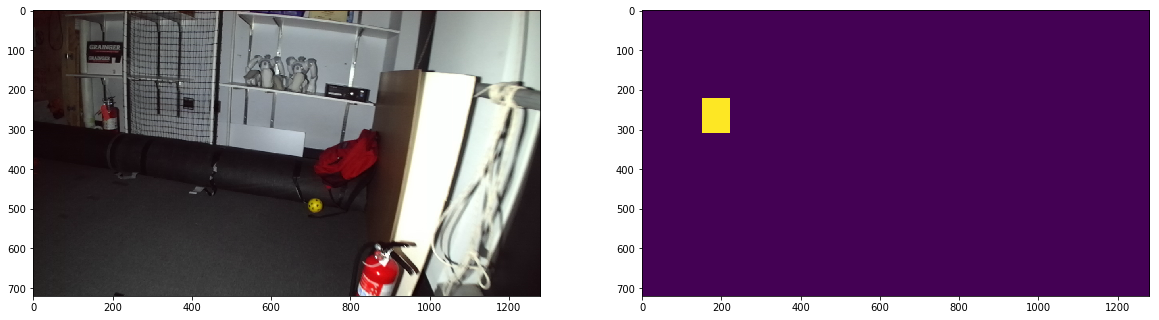

In [50]:
def predict(image, label_img):
    h, w = image.shape[:2]
    tmp_img = image.copy()
    generate_img = np.zeros(image.shape, np.uint8)
    # generate_img = image.copy()
    img = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
    x = cv2.resize(img, (300, 300)).astype(np.float32)
    x -= (104.0, 117.0, 123.0)
    x = x.astype(np.float32)
    x = x[:, :, ::-1].copy()
    x = torch.from_numpy(x).permute(2, 0, 1)

    #SSD Forward Pass
    xx = Variable(x.unsqueeze(0))     # wrap tensor in Variable
    if torch.cuda.is_available():
        xx = xx.cuda()
    y = net(xx)
    # print(1./(t2-t1))
    scale = torch.Tensor(image.shape[1::-1]).repeat(2)
    detections = y.data	# torch.Size([1, 4, 200, 5]) --> [batch?, class, object, coordinates]
    objs = []
    for i in range(detections.size(1)): # detections.size(1) --> class size
        for j in range(5):	# each class choose top 5 predictions
            if detections[0, i, j, 0].numpy() > prob_threshold:
                score = detections[0, i, j, 0]
                pt = (detections[0, i, j,1:]*scale).cpu().numpy()
                objs.append([pt[0], pt[1], pt[2]-pt[0]+1, pt[3]-pt[1]+1, i])
    #objs = bbx(img, label_img)
    for obj in objs:
        region = [int(obj[1] - border), int(obj[1] + obj[3] + border),\
                  int(obj[0] - border), int(obj[0] + obj[2] + border)]
        if region[0] < 0:
            region[0] = 0
        if region[1] > w-1:
            region[1] = w-1
        if region[2] < 0:
            region[2] = 0
        if region[3] > h-1:
            region[3] = h-1

        bbx_img = image[region[0] : region[1], region[2]: region[3]]
        if bbx_img.shape[0] == 0 or bbx_img.shape[1]==0:
            continue

        mask = generate_image(bbx_img)
        # lis = []
        # for i in range(mask.shape[0]):
        # 	for j in range(mask.shape[1]):
        # 		if mask[i][j] not in lis:
        # 			lis.append(mask[i][j])
        # print(lis)
        #print(mask.transpose(2,0,1).shape)
        #output.transpose(0, 2, 3, 1).reshape(-1, n_class).argmax(axis = 1).reshape(N, h, w)
        #mask = mask.transpose(2, 0, 1).reshape(-1, 2).argmax(axis = 1).reshape(256, 256, 1)
        mask = cv2.resize(mask, (region[3]-region[2], region[1]-region[0]))
        
        # add class label to mask
        if obj[4] == 1: #extinguisher
            label = 1
        elif obj[4] == 3: #drill
            label = 3
        elif obj[4] == 2: #backpack
            label = 2
        elif obj[4] == 4: #supervivor
            label = 4
        else:
            continue
        ret, mask = cv2.threshold(mask, 100, label, cv2.THRESH_BINARY) # pixel value only belongs to 0 or 255
        
        if generate_img[region[0] : region[1], region[2]: region[3]].shape[:2] == mask.shape:
            generate_img[region[0] : region[1], region[2]: region[3]] = cv2.cvtColor(mask, cv2.COLOR_GRAY2BGR)
    
    generate_img = generate_img[:,:,0]
    return generate_img
generate_img = predict(cv_image, label_img)
show_img(cv_image, generate_img)

- predict_2ch: please use "sigmoid" activation function

In [51]:
def predict_2ch(image, label_img):
    h, w = image.shape[:2]
    tmp_img = image.copy()
    generate_img = np.zeros(image.shape, np.uint8)
    # generate_img = image.copy()
    img = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
    
    x = cv2.resize(img, (300, 300)).astype(np.float32)
    x -= (104.0, 117.0, 123.0)
    x = x.astype(np.float32)
    x = x[:, :, ::-1].copy()
    x = torch.from_numpy(x).permute(2, 0, 1)

    #SSD Forward Pass
    xx = Variable(x.unsqueeze(0))     # wrap tensor in Variable
    if torch.cuda.is_available():
        xx = xx.cuda()
    y = net(xx)
    # print(1./(t2-t1))
    scale = torch.Tensor(image.shape[1::-1]).repeat(2)
    detections = y.data	# torch.Size([1, 4, 200, 5]) --> [batch?, class, object, coordinates]
    objs = []
    for i in range(detections.size(1)): # detections.size(1) --> class size
        for j in range(5):	# each class choose top 5 predictions
            if detections[0, i, j, 0].numpy() > prob_threshold:
                score = detections[0, i, j, 0]
                pt = (detections[0, i, j,1:]*scale).cpu().numpy()
                objs.append([pt[0], pt[1], pt[2]-pt[0]+1, pt[3]-pt[1]+1, i])
                
    #objs = bbx(img, label_img)
    
    for obj in objs:
        region = [int(obj[1] - border), int(obj[1] + obj[3] + border),\
                  int(obj[0] - border), int(obj[0] + obj[2] + border)]
        if region[0] < 0:
            region[0] = 0
        if region[1] > h-1:
            region[1] = h-1
        if region[2] < 0:
            region[2] = 0
        if region[3] > w-1:
            region[3] = w-1

        bbx_img = image[region[0] : region[1], region[2]: region[3]]
        if bbx_img.shape[0] == 0 or bbx_img.shape[1]==0:
            continue

        mask = generate_image_2ch(bbx_img)
        # lis = []
        # for i in range(mask.shape[0]):
        # 	for j in range(mask.shape[1]):
        # 		if mask[i][j] not in lis:
        # 			lis.append(mask[i][j])
        # print(lis)
        mask = mask.reshape(-1, 2).argmax(axis=1).reshape(256, 256).astype(np.uint8)
        mask = 1 - mask # conver 1 to 0, 0 to 1
        #mask[mask!=0] = 255
        mask = cv2.resize(mask, (region[3]-region[2], region[1]-region[0]))
        
        # add class label to mask
        if obj[4] == 1: # extinguisher
            label = 1
        elif obj[4] == 3: # drill
            label = 3
        elif obj[4] == 2: # backpack
            label = 2
        elif obj[4] == 4: # supervivor
            label = 4
        else:
            continue
        mask[mask!=0] = label
        #ret, mask = cv2.threshold(mask, 100, label, cv2.THRESH_BINARY) # pixel value only belongs to 0 or 255
        
        if generate_img[region[0] : region[1], region[2]: region[3]].shape[:2] == mask.shape:
            generate_img[region[0] : region[1], region[2]: region[3]] = cv2.cvtColor(mask, cv2.COLOR_GRAY2BGR)
    
    generate_img = generate_img[:,:,0]
    return generate_img


(720, 1280)


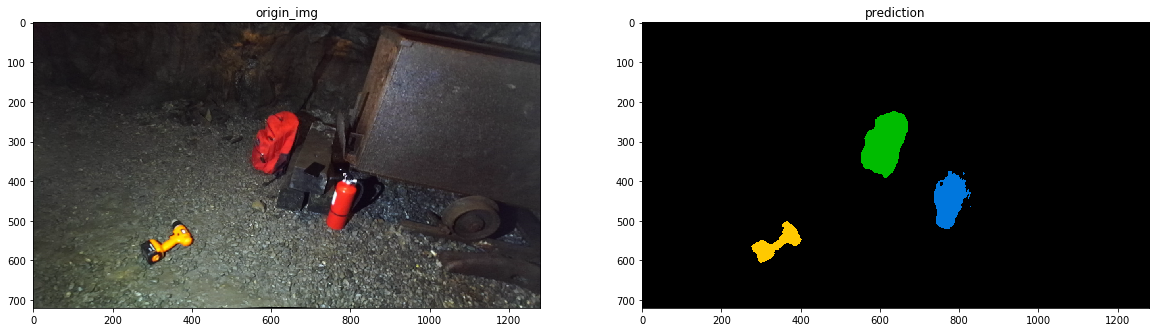

In [52]:
label_img = cv2.imread("/media/arg_ws3/5E703E3A703E18EB/data/PST900_RGBT_Dataset/test/labels/61_bag24_rect_rgb_frame0000000649.png", cv2.IMREAD_UNCHANGED)
cv_image = cv2.imread("/media/arg_ws3/5E703E3A703E18EB/data/PST900_RGBT_Dataset/test/rgb/61_bag24_rect_rgb_frame0000000649.png", cv2.IMREAD_UNCHANGED)
pred = predict_2ch(cv_image, label_img)
print(pred.shape)
fig=plt.figure(figsize=(20, 20))
plt.subplot(1, 2, 1)
plt.title("origin_img")
plt.imshow(cv_image[:, :, ::-1]) #RGB2BGR
#print(img.shape, pred[0].shape)
#print(np.unique(_img[i]))

plt.subplot(1, 2, 2)
plt.title("prediction")
plt.imshow(pred,cmap = "nipy_spectral",vmin = 0, vmax = n_class - 1)

plt.show()
cmap = plt.cm.nipy_spectral
norm = plt.Normalize(vmin=pred.min(), vmax=n_class - 1)
image = cmap(norm(pred))
x, y = 230, 200
h, w = 480, 640
image = image[y:y+h, x:x+w]
label_img = cmap(norm(label_img))
label_img = label_img[y:y+h, x:x+w]
#plt.imsave('/home/arg_ws3/Desktop/thesis/image/PST_ssd_gan.png', image)
plt.imsave('/home/arg_ws3/Desktop/thesis/image/PST_label.png', label_img)
#generate_img = predict(cv_image)

extinguisher: 1

drill: 3

backpack: 2

In [53]:
def analysis(pred, target, h, w):
    # TP, FN, FP, TN
    TP = np.zeros(n_class, dtype = np.float128)
    FN = np.zeros(n_class, dtype = np.float128)
    FP = np.zeros(n_class, dtype = np.float128)

    target = target.reshape(h * w)
    pred = pred.reshape(h * w)
    
    con_matrix = confusion_matrix(target, pred,labels = np.arange(0,n_class,1))
    con_matrix[0][0] = 0
    for i in range(0, n_class):
        for j in range(0, n_class):
            if i == j:
                TP[i] += con_matrix[i][j]
            if i != j:
                FP[j] += con_matrix[i][j]
                FN[i] += con_matrix[i][j]
    return TP, FN, FP
                
def pixel_acc(pred, target):
    correct = (pred == target).sum()
    total   = (target == target).sum()
    return correct / total

In [54]:
a = '/media/arg_ws3/5E703E3A703E18EB/data/PSTRGB_Dataset/labels/70_ghost_aug_6_bag_1_rgb_frame100560.png'
a = cv2.imread(a, cv2.IMREAD_GRAYSCALE)
check = a[a!=0]
check = check[check!=4]
len(check)

0

- Use predict(input_img) for 1 channel output version
- Use predict_2ch(input_img) for 2 channel output version

In [55]:
def val(data_dir, score_dir, name):
    #score_dir = "/media/arg_ws3/5E703E3A703E18EB/research/subt_fcn/scores/gan_ssd_622"
    if not os.path.exists(score_dir):
        os.makedirs(score_dir)
    TP = np.zeros(n_class-1, dtype = np.float128)
    FN = np.zeros(n_class-1, dtype = np.float128)
    FP = np.zeros(n_class-1, dtype = np.float128)
    total_ious = []
    pixel_accs = []
    data_list = os.listdir(os.path.join(data_dir, 'rgb'))
    rgb_dir = os.path.join(data_dir, 'rgb')
    label_dir = os.path.join(data_dir, 'labels')
    
    for idx in range(len(data_list)):
        if idx % 10 == 0:
            print(idx/len(data_list))
        data_name = data_list[idx]
        input_img = cv2.imread(os.path.join(rgb_dir, data_name),cv2.IMREAD_UNCHANGED)
        target = cv2.imread(os.path.join(label_dir, data_name), cv2.IMREAD_GRAYSCALE)
        check = target[target!=0]
        #check = check[check!=4]
        if len(check)==0:
            continue
        
        # Change your prediction here
        pred = predict_2ch(input_img, target)

        h, w = pred.shape

        pixel_accs.append(pixel_acc(pred, target))
        _TP, _FN, _FP =  analysis(pred, target, h, w)
        TP += _TP[1:n_class]
        FN += _FN[1:n_class]
        FP += _FP[1:n_class]
            
    recall = TP / (TP + FN)
    precision = TP / (TP + FP)
    ious = TP / (TP + FN + FP)
    fscore = 2*TP / (2*TP + FN + FP)
    total_ious = np.array(total_ious).T  # n_class * val_len
    pixel_accs = np.array(pixel_accs).mean()
    
    print("name: {}, pix_acc: {}, meanIoU: {}, IoUs: {}, recall: {}, precision: {}, fscore: {}"\
          .format(name, pixel_accs, np.nanmean(ious), ious, recall, precision, fscore))
    
    f1 = open(score_dir + "/cls_acc_log.txt","a+")
    f1.write('name:'+ str(name) + ', pix_acc: ' + str(pixel_accs) + '\n' )
    f2 = open(score_dir + "/cls_iou_log.txt","a+")
    f2.write('name:'+ str(name) + ', class ious: ' + str(ious) + '\n' )
    f3 = open(score_dir + "/mean_iou_log.txt","a+")
    f3.write('name:'+ str(name) + ', mean IoU: ' + str(np.nanmean(ious)) + '\n' ) 
    f4 = open(score_dir + "/recall_log.txt","a+")
    f4.write('name:'+ str(name) + ', class recall: ' + str(recall) + '\n' )
    f5 = open(score_dir + "/precision_log.txt","a+")
    f5.write('name:'+ str(name) + ', class precision: ' + str(precision) + '\n' )    
    f6 = open(score_dir + "/fscore_log.txt","a+")
    f6.write('name:'+ str(name) + ', class fscore: ' + str(fscore) + '\n' )
    f7 = open(score_dir + "/mean_fscore_log.txt","a+")
    f7.write('name:'+ str(name) + ', mean fscore: ' + str(np.nanmean(fscore)) + '\n' )
    f8 = open(score_dir + "/mean_precision_log.txt","a+")
    f8.write('name:'+ str(name) + ', mean precision: ' + str(np.nanmean(precision)) + '\n' ) 
    f9 = open(score_dir + "/mean_recall_log.txt","a+")
    f9.write('name:'+ str(name) + ', mean recall: ' + str(np.nanmean(recall)) + '\n' ) 

In [57]:
#data_dir = '/media/arg_ws3/5E703E3A703E18EB/data/PSTRGB_Dataset/'
data_dir = '/media/arg_ws3/5E703E3A703E18EB/data/PST900_RGBT_Dataset/test/'
score_dir = "/media/arg_ws3/5E703E3A703E18EB/research/subt_fcn/scores/gan_ssd_PSTRGBT"
name = 'gan_ssd_PSTRGBT_adv_20_epoch195'

In [58]:
val(data_dir, score_dir, name)

0.0
0.034722222222222224
0.06944444444444445
0.10416666666666667
0.1388888888888889
0.1736111111111111
0.20833333333333334
0.24305555555555555
0.2777777777777778
0.3125
0.3472222222222222
0.3819444444444444
0.4166666666666667
0.4513888888888889
0.4861111111111111
0.5208333333333334
0.5555555555555556
0.5902777777777778
0.625
0.6597222222222222
0.6944444444444444
0.7291666666666666
0.7638888888888888
0.7986111111111112
0.8333333333333334
0.8680555555555556
0.9027777777777778
0.9375
0.9722222222222222
name: gan_ssd_PSTRGBT_adv_20_epoch195, pix_acc: 0.9883133016055662, meanIoU: 0.5903971888482108, IoUs: [0.61370222 0.76019594 0.58843908 0.39925152], recall: [0.78211244 0.79333491 0.79086909 0.47200277], precision: [0.74026575 0.94791345 0.69687407 0.72147202], fscore: [0.76061396 0.86376286 0.74090229 0.57066441]
